# Multi-group Agreement (COMPAS)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the COMPAS
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from compas_utils import months_since, preprocess_compas

# COMPAS Dataset
Parole records from Florida, USA, where the task is to predict whether an individual will recidivate within two years. Sensitive attributes are race and gender.
While every labeled dataset contains human biases inherent in collecting and categorizing the data, the COMPAS dataset in particular has been the subject of valid critiques, and is mostly included for comparisons to prior work. We note that the COMPAS dataset reflects the patterns of policing and social processes in a particular community (South Florida) at a specific time, and as others have noted [69], each stage of the COMPAS dataset’s creation introduces opportunities for bias [60, 4] and that measurement biases and errors with COMPAS have been widely documented [3].

COMPAS has $n = 7,215$ instances total, with $d = 10$ features.

In [2]:
compas_data = pd.read_csv("./datasets/compas/compas.csv", header=0, na_values='?')
compas_df = preprocess_compas(compas_data)
compas_df = compas_df.dropna()
print("COMPAS Shape: {}".format(compas_df.shape))

X, y = compas_df.drop("is_recid", axis=1), compas_df["is_recid"]
cat_idx = ['c_charge_degree', 'sex', 'race', 'screening_year_is_2013']
num_idx = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'age']
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variale so we have two classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples recidivate (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples NOT recidivate (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

COMPAS Shape: (7214, 10)
% examples recidivate (y=1): 48.11477682284447
% examples NOT recidivate (y=0): 51.88522317715553


In [3]:
def compas_gp_indices(df, race_val, sex_val):
    if race_val == "NotWhite":
        return np.where((df['race'] != 1) & (df['sex'] == sex_val))
    else:
        return np.where((df['race'] == 1) & (df['sex'] == sex_val))

group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
race_gps_coarse = ["White", "NotWhite"]
sex_gps = [1, 0]

# Traditional disjoint groups
for race in race_gps_coarse:
    for sex in sex_gps:
        indices = compas_gp_indices(X, race, sex)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
w_indices = np.where(X['race'] == 1)
w_membership = np.zeros(y.shape[0], dtype=bool)
w_membership[w_indices] = True
group_memberships.append(w_membership)

nw_indices = np.where(X['race'] != 1)
nw_membership = np.zeros(y.shape[0], dtype=bool)
nw_membership[nw_indices] = True
group_memberships.append(nw_membership)

m_indices = np.where(X['sex'] == 1)
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 0)
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [4]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (7214, 14)


In [5]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			5771	1443
1 (W,M)			2428	616
2 (W,F)			522	130
3 (nW,M)			2212	563
4 (nW,F)			609	134
5 (W)			2950	746
6 (nW)			2821	697
7 (M)			4640	1179
8 (F)			1131	264


In [6]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.48995148995148996
P(Y=1 | group 1) = 0.5909090909090909
P(Y=1 | group 2) = 0.4461538461538462
P(Y=1 | group 3) = 0.42451154529307283
P(Y=1 | group 4) = 0.34328358208955223
P(Y=1 | group 5) = 0.5656836461126006
P(Y=1 | group 6) = 0.40889526542324245
P(Y=1 | group 7) = 0.5114503816793893
P(Y=1 | group 8) = 0.3939393939393939


## Utilities for Training/Evaluation

In [11]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names):
    # Get test errors for each group
    test_err = {}
    std_errs = {}
    print("Group-conditional ERM Test Errors")
    for g in range(num_groups):
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        std_errs[g] = std_err(test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, test_err[g], std_errs[g], num_group_test[g], group_names[g]))

    print()

    erm_test_err = {}
    erm_std_errs = {}
    print("Overall ERM Test Errors")
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
        erm_std_errs[g] = std_err(erm_test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, erm_test_err[g], erm_std_errs[g], num_group_test[g], group_names[g]))

    return test_err, std_errs, erm_test_err, erm_std_errs
    
def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [12]:
XTICKS = ('G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)')
def plot_compas_agreements(ax, group_pairs_agreements, group_pairs, group_names, model_class, bar_width=0.2, bar_groups=4, xticks=XTICKS, legend=True):
       # Plot "agreement" for each pair of intersecting groups
       index = np.arange(bar_groups)
       num_group_pairs = len(group_pairs_agreements)

       for i in range(0, num_group_pairs, 3):
              ax.bar(i/(bar_groups - 1) - bar_width, group_pairs_agreements[i], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i][0], group_names[group_pairs[i][0]],
                                                        group_pairs[i][1], group_names[group_pairs[i][1]]))
              ax.bar(i/(bar_groups - 1), group_pairs_agreements[i+1], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+1][0], group_names[group_pairs[i+1][0]],
                                                        group_pairs[i+1][1], group_names[group_pairs[i+1][1]]))
              ax.bar(i/(bar_groups - 1) + bar_width, group_pairs_agreements[i+2], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+2][0], group_names[group_pairs[i+2][0]],
                                                        group_pairs[i+2][1], group_names[group_pairs[i+2][1]]))

       ax.set_xlabel('Intersecting Group')
       ax.set_ylabel('Agreement')
       ax.set_title('Group Agreements ({})'.format(model_class))
       ax.set_xticks(index, xticks)
       if legend:
              ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                     fancybox=True, shadow=True, ncol=3)

def plot_compas_errors(ax, test_err, std_errs, erm_test_err, erm_std_errs, model_class, num_groups=num_groups, bar_width=0.2):
       # Error rate plots
       index = np.arange(num_groups)

       for g in range(num_groups):
              if g == 0:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, label="Group-ERM", color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, label="ERM", color="orange")
              else:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, color="orange")
              ax.set_ylabel('Group-conditional Error Rate')
              ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM ({})'.format(model_class))

       xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
       ax.set_xticks(index, xticks)
       ax.set_ylim([0, 0.5])
       ax.legend()

In [13]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (W,M)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (W,F)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (nW,M)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (nW,F)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [16]:
# Train LogisticRegression models, one per group
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.30561330561330563 (+/-0.017150178978937294; n=1443)
group 1 (W,M): 0.3003246753246753 (+/-0.02611971469657606; n=616)
group 2 (W,F): 0.3230769230769231 (+/-0.05800506938748756; n=130)
group 3 (nW,M): 0.3019538188277087 (+/-0.02736359421167892; n=563)
group 4 (nW,F): 0.2462686567164179 (+/-0.05263510057433427; n=134)
group 5 (W): 0.31233243967828417 (+/-0.023996251204253295; n=746)
group 6 (nW): 0.28694404591104733 (+/-0.024230312923147472; n=697)
group 7 (M): 0.30788804071246817 (+/-0.019012651254262512; n=1179)
group 8 (F): 0.2765151515151515 (+/-0.038930252559886476; n=264)
PREPEND group 0 (ALL): 0.30145530145530147 (+/-0.01708403276683732; n=1443)
PREPEND group 1 (W,M): 0.3003246753246753 (+/-0.02611971469657606; n=616)
PREPEND group 2 (W,F): 0.3230769230769231 (+/-0.05800506938748756; n=130)
PREPEND group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
PREPEND group 4 (nW,F): 0.2462686567164179 (+/-0.05263510057433427; n=134)
PREPEND group 5 (W): 0.30

(W,M, W) agreement on G1 (W,M):	0.9772727272727273
(W, M) agreement on G1 (W,M):	0.9561688311688312
(W,M, M) agreement on G1 (W,M):	0.9496753246753247
(W,F, W) agreement on G2 (W,F):	0.9230769230769231
(W, F) agreement on G2 (W,F):	0.8923076923076924
(W,F, F) agreement on G2 (W,F):	0.9230769230769231
(nW,M, nW) agreement on G3 (nW,M):	0.9857904085257548
(nW, M) agreement on G3 (nW,M):	0.955595026642984
(nW,M, M) agreement on G3 (nW,M):	0.9662522202486679
(nW,F, nW) agreement on G4 (nW,F):	0.9477611940298507
(nW, F) agreement on G4 (nW,F):	0.9477611940298507
(nW,F, F) agreement on G4 (nW,F):	0.9701492537313433


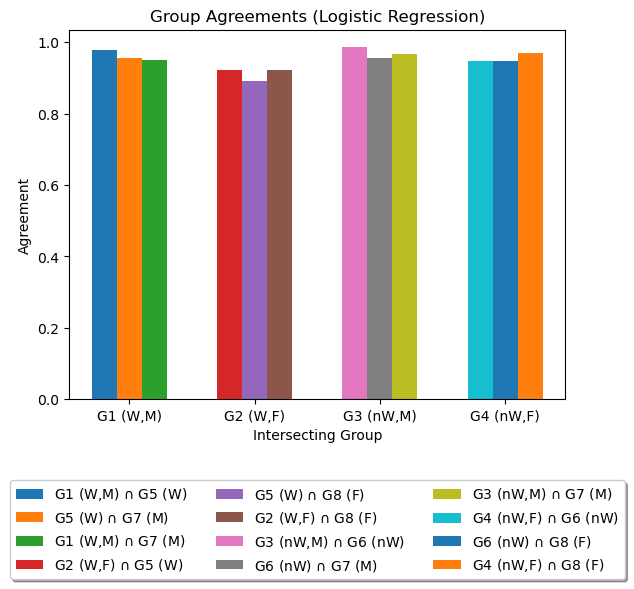

In [17]:
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_compas_agreements(ax, lr_group_pairs_agreements, group_pairs, group_names, model_class="Logistic Regression")

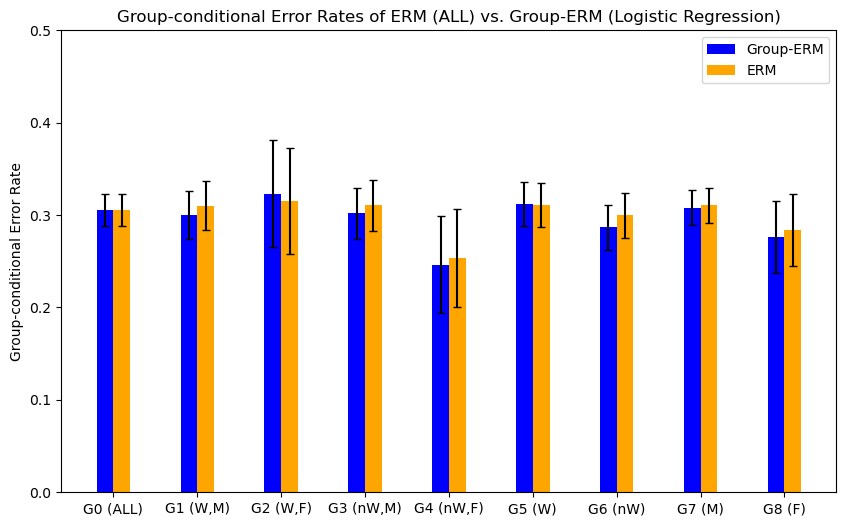

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_compas_errors(ax, lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err, model_class="Logistic Regression")

# Decision Trees

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.3049203049203049 (+/-0.017139269429391337; n=1443)
group 1 (W,M): 0.30844155844155846 (+/-0.026316342477415815; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.31616341030195383 (+/-0.02771358896745721; n=563)
group 4 (nW,F): 0.27611940298507465 (+/-0.05461909871538712; n=134)
group 5 (W): 0.33646112600536193 (+/-0.024465056148844793; n=746)
group 6 (nW): 0.2855093256814921 (+/-0.024193964566902607; n=697)
group 7 (M): 0.3104325699745547 (+/-0.019055928107901656; n=1179)
group 8 (F): 0.3143939393939394 (+/-0.04040986886909458; n=264)
Group-conditional ERM Test Errors
group 0 (ALL): 0.3049203049203049 (+/-0.017139269429391337; n=1443)
group 1 (W,M): 0.30844155844155846 (+/-0.026316342477415815; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.31616341030195383 (+/-0.02771358896745721; n=563)
group 4 (nW,F): 0.27611940298507465 (+/-0.05461909871538712; n=134)
group 5 (W): 0.33646112600

(W,M, W) agreement on G1 (W,M):	0.8847402597402597
(W, M) agreement on G1 (W,M):	0.875
(W,M, M) agreement on G1 (W,M):	0.922077922077922
(W,F, W) agreement on G2 (W,F):	0.8692307692307693
(W, F) agreement on G2 (W,F):	0.8384615384615385
(W,F, F) agreement on G2 (W,F):	0.8461538461538461
(nW,M, nW) agreement on G3 (nW,M):	0.8738898756660746
(nW, M) agreement on G3 (nW,M):	0.8809946714031972
(nW,M, M) agreement on G3 (nW,M):	0.8543516873889876
(nW,F, nW) agreement on G4 (nW,F):	0.8582089552238806
(nW, F) agreement on G4 (nW,F):	0.8805970149253731
(nW,F, F) agreement on G4 (nW,F):	0.8582089552238806


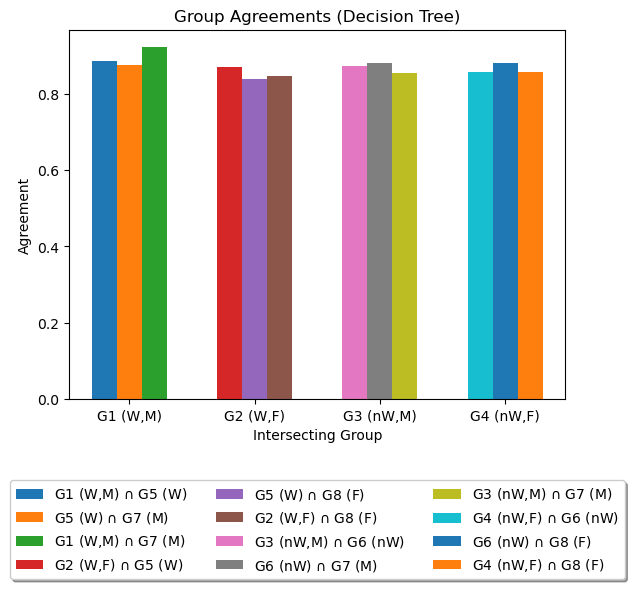

In [22]:
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_compas_agreements(ax, dt_group_pairs_agreements, group_pairs, group_names, model_class="Decision Tree")

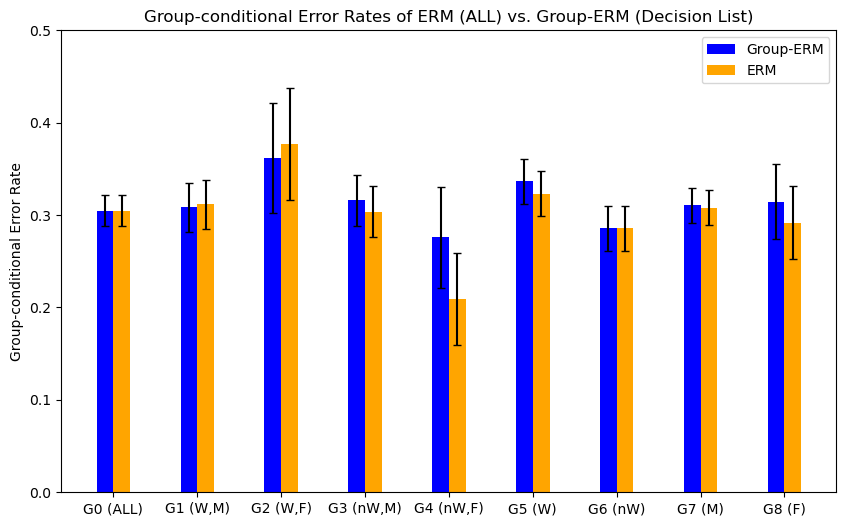

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_compas_errors(ax, dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err, model_class="Decision List")

# Random Forests

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.3042273042273042 (+/-0.01712831407006342; n=1443)
group 1 (W,M): 0.31655844155844154 (+/-0.026503442231502902; n=616)
group 2 (W,F): 0.35384615384615387 (+/-0.05930871686541635; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.32439678284182305 (+/-0.0242398377105771; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3104325699745547 (+/-0.019055928107901656; n=1179)
group 8 (F): 0.26515151515151514 (+/-0.038420144373355454; n=264)
Group-conditional ERM Test Errors
group 0 (ALL): 0.3042273042273042 (+/-0.01712831407006342; n=1443)
group 1 (W,M): 0.31655844155844154 (+/-0.026503442231502902; n=616)
group 2 (W,F): 0.35384615384615387 (+/-0.05930871686541635; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.324396782841

(W,M, W) agreement on G1 (W,M):	0.9772727272727273
(W, M) agreement on G1 (W,M):	0.9821428571428571
(W,M, M) agreement on G1 (W,M):	0.9594155844155844
(W,F, W) agreement on G2 (W,F):	0.9461538461538461
(W, F) agreement on G2 (W,F):	0.9461538461538461
(W,F, F) agreement on G2 (W,F):	0.9076923076923077
(nW,M, nW) agreement on G3 (nW,M):	0.9467140319715808
(nW, M) agreement on G3 (nW,M):	0.9271758436944938
(nW,M, M) agreement on G3 (nW,M):	0.9449378330373002
(nW,F, nW) agreement on G4 (nW,F):	0.9328358208955224
(nW, F) agreement on G4 (nW,F):	0.9552238805970149
(nW,F, F) agreement on G4 (nW,F):	0.9776119402985075


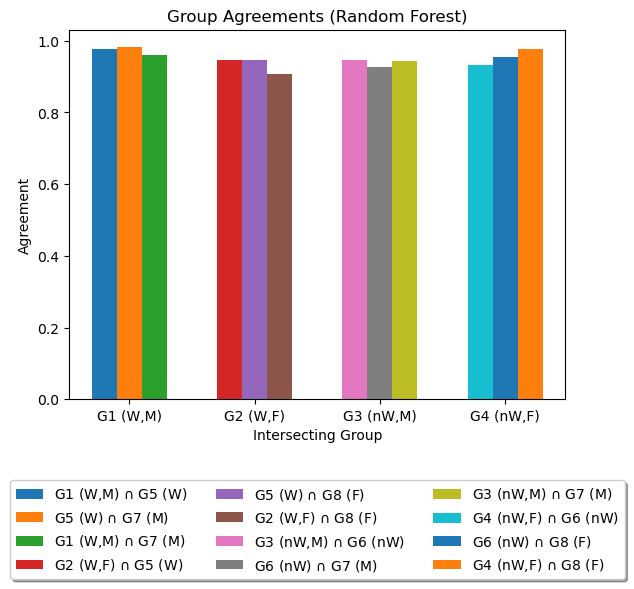

In [26]:
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_compas_agreements(ax, rf_group_pairs_agreements, group_pairs, group_names, model_class="Random Forest")

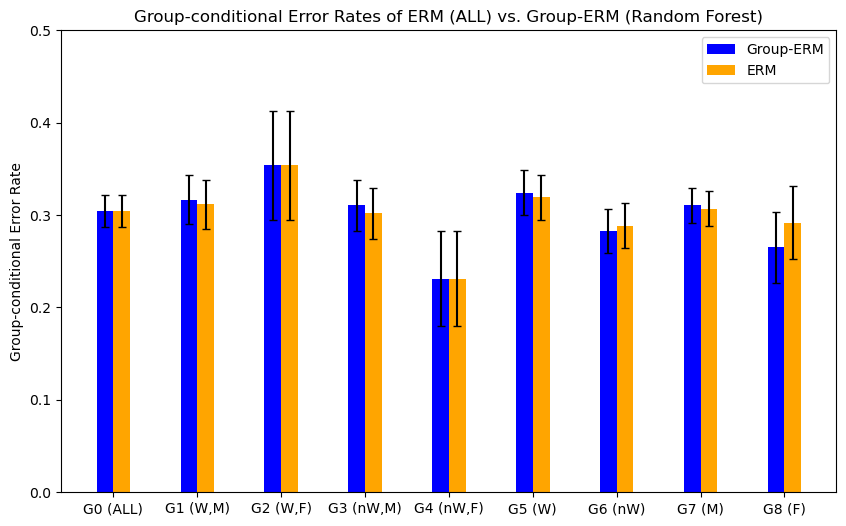

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_compas_errors(ax, rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err, model_class="Random Forest")

# Gradient-Boosted Trees

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.3116883116883117 (+/-0.026392314163407593; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.3019538188277087 (+/-0.02736359421167892; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.3109919571045576 (+/-0.023968028286628383; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3061916878710772 (+/-0.0189834237834141; n=1179)
group 8 (F): 0.2840909090909091 (+/-0.03925279998339531; n=264)
Group-conditional ERM Test Errors
group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.3116883116883117 (+/-0.026392314163407593; n=616)
group 2 (W,F): 0.36153846153846153 (+/-0.05959199770321049; n=130)
group 3 (nW,M): 0.3019538188277087 (+/-0.02736359421167892; n=563)
group 4 (nW,F): 0.23134328358208955 (+/-0.05151779416159831; n=134)
group 5 (W): 0.310991957104557

(W,M, W) agreement on G1 (W,M):	0.9691558441558441
(W, M) agreement on G1 (W,M):	0.935064935064935
(W,M, M) agreement on G1 (W,M):	0.939935064935065
(W,F, W) agreement on G2 (W,F):	0.9230769230769231
(W, F) agreement on G2 (W,F):	0.8692307692307693
(W,F, F) agreement on G2 (W,F):	0.9
(nW,M, nW) agreement on G3 (nW,M):	0.9644760213143873
(nW, M) agreement on G3 (nW,M):	0.9218472468916519
(nW,M, M) agreement on G3 (nW,M):	0.9360568383658969
(nW,F, nW) agreement on G4 (nW,F):	0.9253731343283582
(nW, F) agreement on G4 (nW,F):	0.9253731343283582
(nW,F, F) agreement on G4 (nW,F):	0.9552238805970149


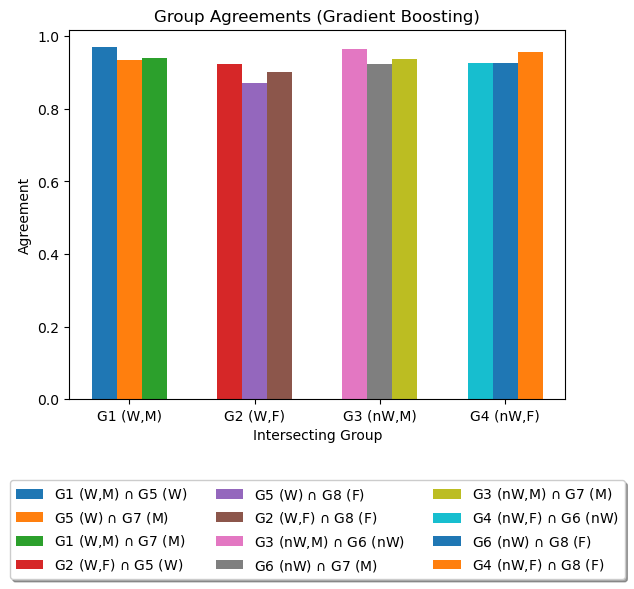

In [33]:
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_compas_agreements(ax, gb_group_pairs_agreements, group_pairs, group_names, model_class="Gradient Boosting")

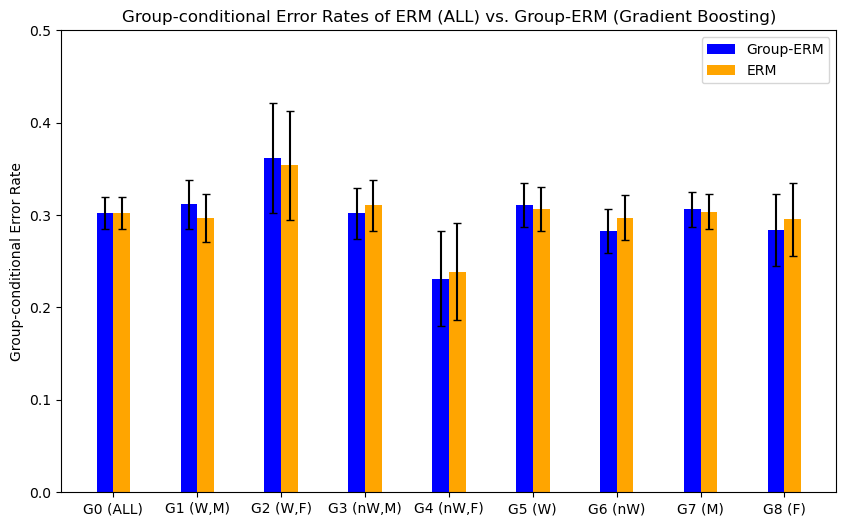

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_compas_errors(ax, gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err, model_class="Gradient Boosting")

# XGBoost

In [36]:
from xgboost import XGBClassifier

In [37]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.306999306999307 (+/-0.01717186099756068; n=1443)
group 1 (W,M): 0.31006493506493504 (+/-0.02635451802786166; n=616)
group 2 (W,F): 0.34615384615384615 (+/-0.05900865137962601; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.21641791044776118 (+/-0.05030966769874355; n=134)
group 5 (W): 0.3109919571045576 (+/-0.023968028286628383; n=746)
group 6 (nW): 0.28407460545193686 (+/-0.024157317018574438; n=697)
group 7 (M): 0.30279898218829515 (+/-0.01892405959375801; n=1179)
group 8 (F): 0.29924242424242425 (+/-0.039857358905334477; n=264)
Group-conditional ERM Test Errors
group 0 (ALL): 0.306999306999307 (+/-0.01717186099756068; n=1443)
group 1 (W,M): 0.31006493506493504 (+/-0.02635451802786166; n=616)
group 2 (W,F): 0.34615384615384615 (+/-0.05900865137962601; n=130)
group 3 (nW,M): 0.3108348134991119 (+/-0.027585908584909908; n=563)
group 4 (nW,F): 0.21641791044776118 (+/-0.05030966769874355; n=134)
group 5 (W): 0.310991957104557

(W,M, W) agreement on G1 (W,M):	0.9724025974025974
(W, M) agreement on G1 (W,M):	0.9301948051948052
(W,M, M) agreement on G1 (W,M):	0.9285714285714286
(W,F, W) agreement on G2 (W,F):	0.9153846153846154
(W, F) agreement on G2 (W,F):	0.8846153846153846
(W,F, F) agreement on G2 (W,F):	0.8923076923076924
(nW,M, nW) agreement on G3 (nW,M):	0.9253996447602132
(nW, M) agreement on G3 (nW,M):	0.9342806394316163
(nW,M, M) agreement on G3 (nW,M):	0.8916518650088809
(nW,F, nW) agreement on G4 (nW,F):	0.9552238805970149
(nW, F) agreement on G4 (nW,F):	0.917910447761194
(nW,F, F) agreement on G4 (nW,F):	0.917910447761194


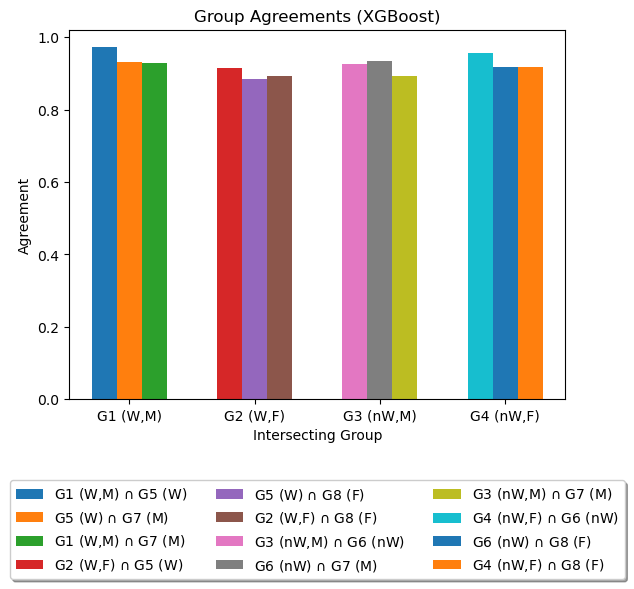

In [38]:
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_compas_agreements(ax, xgb_group_pairs_agreements, group_pairs, group_names, model_class="XGBoost")

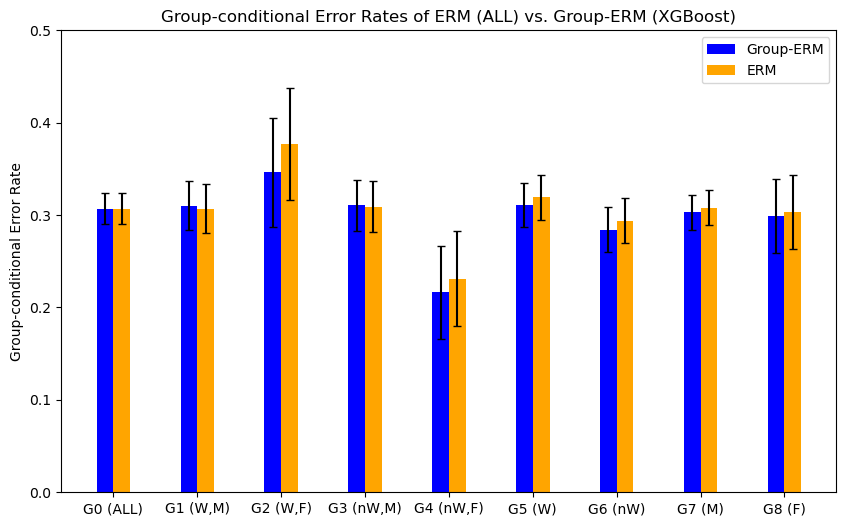

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_compas_errors(ax, xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err, model_class="XGBoost")

# AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
LOAD_DATA = False
SAVE_DATA_PATH = 'compas_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.30194805194805197 (+/-0.026159812657746695; n=616)
group 2 (W,F): 0.3769230769230769 (+/-0.060109140608616406; n=130)
group 3 (nW,M): 0.32149200710479575 (+/-0.027837060571975547; n=563)
group 4 (nW,F): 0.26865671641791045 (+/-0.05415294608121959; n=134)
group 5 (W): 0.3096514745308311 (+/-0.023939570865446836; n=746)
group 6 (nW): 0.28263988522238165 (+/-0.024120368914420633; n=697)
group 7 (M): 0.3087362171331637 (+/-0.019027151947119535; n=1179)
group 8 (F): 0.29924242424242425 (+/-0.039857358905334477; n=264)
Group-conditional ERM Test Errors
group 0 (ALL): 0.30214830214830213 (+/-0.017095172250837197; n=1443)
group 1 (W,M): 0.30194805194805197 (+/-0.026159812657746695; n=616)
group 2 (W,F): 0.3769230769230769 (+/-0.060109140608616406; n=130)
group 3 (nW,M): 0.32149200710479575 (+/-0.027837060571975547; n=563)
group 4 (nW,F): 0.26865671641791045 (+/-0.05415294608121959; n=134)
group 5 (W): 0.30965

(W,M, W) agreement on G1 (W,M):	0.9675324675324676
(W, M) agreement on G1 (W,M):	0.9090909090909091
(W,M, M) agreement on G1 (W,M):	0.9318181818181818
(W,F, W) agreement on G2 (W,F):	0.8769230769230769
(W, F) agreement on G2 (W,F):	0.8769230769230769
(W,F, F) agreement on G2 (W,F):	0.8769230769230769
(nW,M, nW) agreement on G3 (nW,M):	0.9058614564831261
(nW, M) agreement on G3 (nW,M):	0.911190053285968
(nW,M, M) agreement on G3 (nW,M):	0.8774422735346359
(nW,F, nW) agreement on G4 (nW,F):	0.9029850746268657
(nW, F) agreement on G4 (nW,F):	0.9328358208955224
(nW,F, F) agreement on G4 (nW,F):	0.8955223880597015


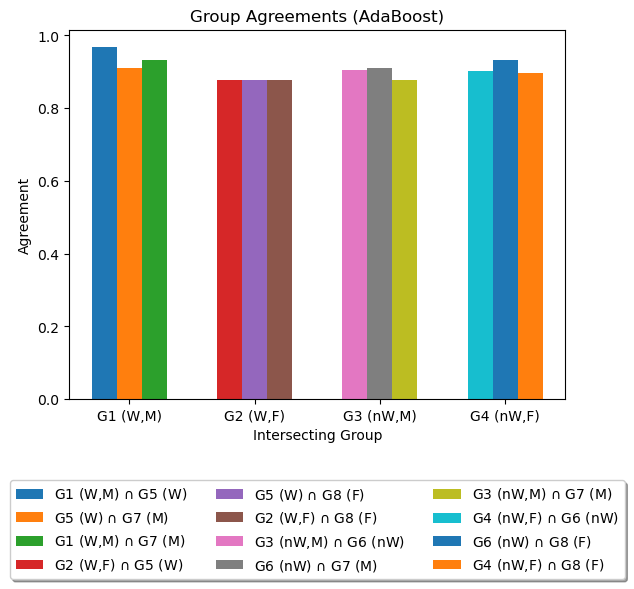

In [43]:
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_compas_agreements(ax, ada_group_pairs_agreements, group_pairs, group_names, model_class="AdaBoost")

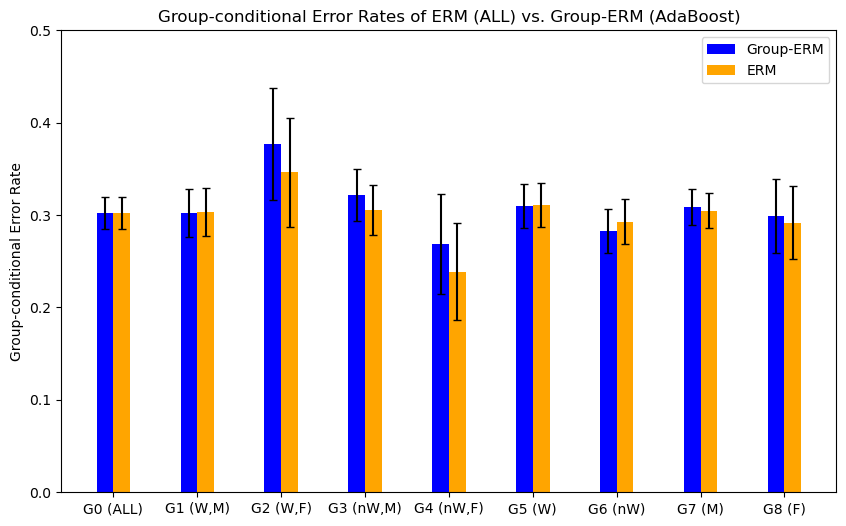

In [44]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_compas_errors(ax, ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err, model_class="AdaBoost")

# All Together

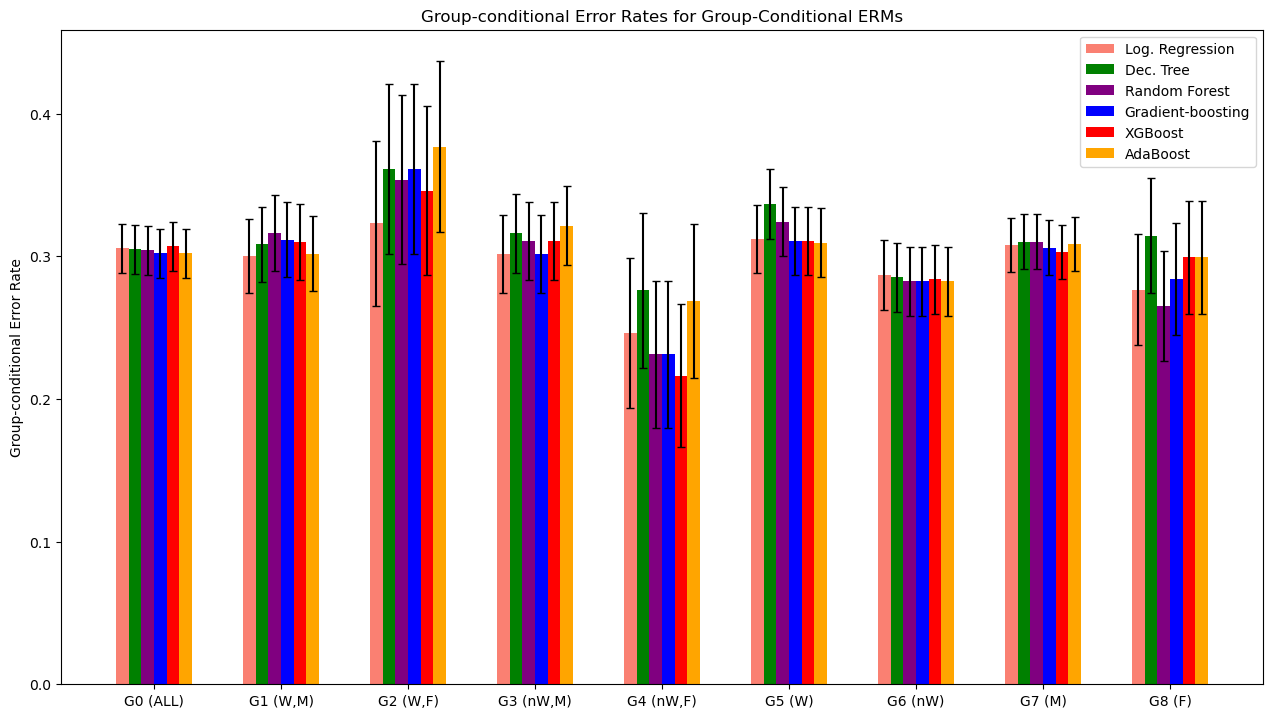

In [45]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, lr_test_err[g], bar_width, yerr=lr_std_err[g], capsize=3, label="Log. Regression", color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_test_err[g], bar_width, yerr=dt_std_err[g], capsize=3, label="Dec. Tree", color="green")
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, yerr=rf_std_err[g], capsize=3, label="Random Forest", color="purple")
        ax.bar(g + 0.5 * bar_width, gb_test_err[g], bar_width, yerr=gb_std_err[g], capsize=3, label="Gradient-boosting", color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_test_err[g], bar_width, yerr=xgb_std_err[g], capsize=3, label="XGBoost", color="red")
        ax.bar(g + 2.5 * bar_width, ada_test_err[g], bar_width, yerr=ada_std_err[g], capsize=3, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, lr_test_err[g], bar_width, yerr=lr_std_err[g], capsize=3, color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_test_err[g], bar_width, yerr=dt_std_err[g], capsize=3, color="green")
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, yerr=rf_std_err[g], capsize=3, color="purple")
        ax.bar(g + 0.5 * bar_width, gb_test_err[g], bar_width, yerr=gb_std_err[g], capsize=3, color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_test_err[g], bar_width, yerr=xgb_std_err[g], capsize=3, color="red")
        ax.bar(g + 2.5 * bar_width, ada_test_err[g], bar_width, yerr=ada_std_err[g], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for Group-Conditional ERMs')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

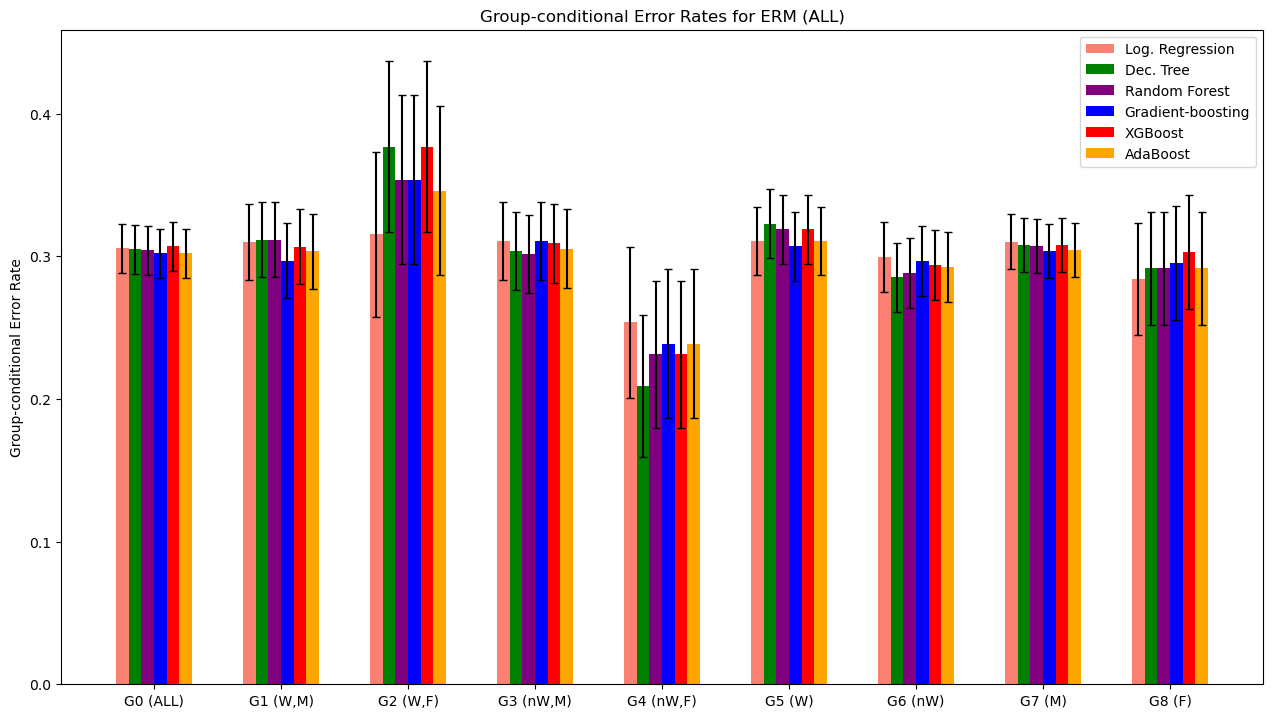

In [46]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, lr_erm_test_err[g], bar_width, yerr=lr_erm_std_err[g], capsize=3, label="Log. Regression", color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_erm_test_err[g], bar_width, yerr=dt_erm_std_err[g], capsize=3, label="Dec. Tree", color="green")
        ax.bar(g - 0.5 * bar_width, rf_erm_test_err[g], bar_width, yerr=rf_erm_std_err[g], capsize=3, label="Random Forest", color="purple")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, yerr=gb_erm_std_err[g], capsize=3, label="Gradient-boosting", color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_erm_test_err[g], bar_width, yerr=xgb_erm_std_err[g], capsize=3, label="XGBoost", color="red")
        ax.bar(g + 2.5 * bar_width, ada_erm_test_err[g], bar_width, yerr=ada_erm_std_err[g], capsize=3, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, lr_erm_test_err[g], bar_width, yerr=lr_erm_std_err[g], capsize=3, color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_erm_test_err[g], bar_width, yerr=dt_erm_std_err[g], capsize=3, color="green")
        ax.bar(g - 0.5 * bar_width, rf_erm_test_err[g], bar_width, yerr=rf_erm_std_err[g], capsize=3, color="purple")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, yerr=gb_erm_std_err[g], capsize=3, color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_erm_test_err[g], bar_width, yerr=xgb_erm_std_err[g], capsize=3, color="red")
        ax.bar(g + 2.5 * bar_width, ada_erm_test_err[g], bar_width, yerr=ada_erm_std_err[g], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for ERM (ALL)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

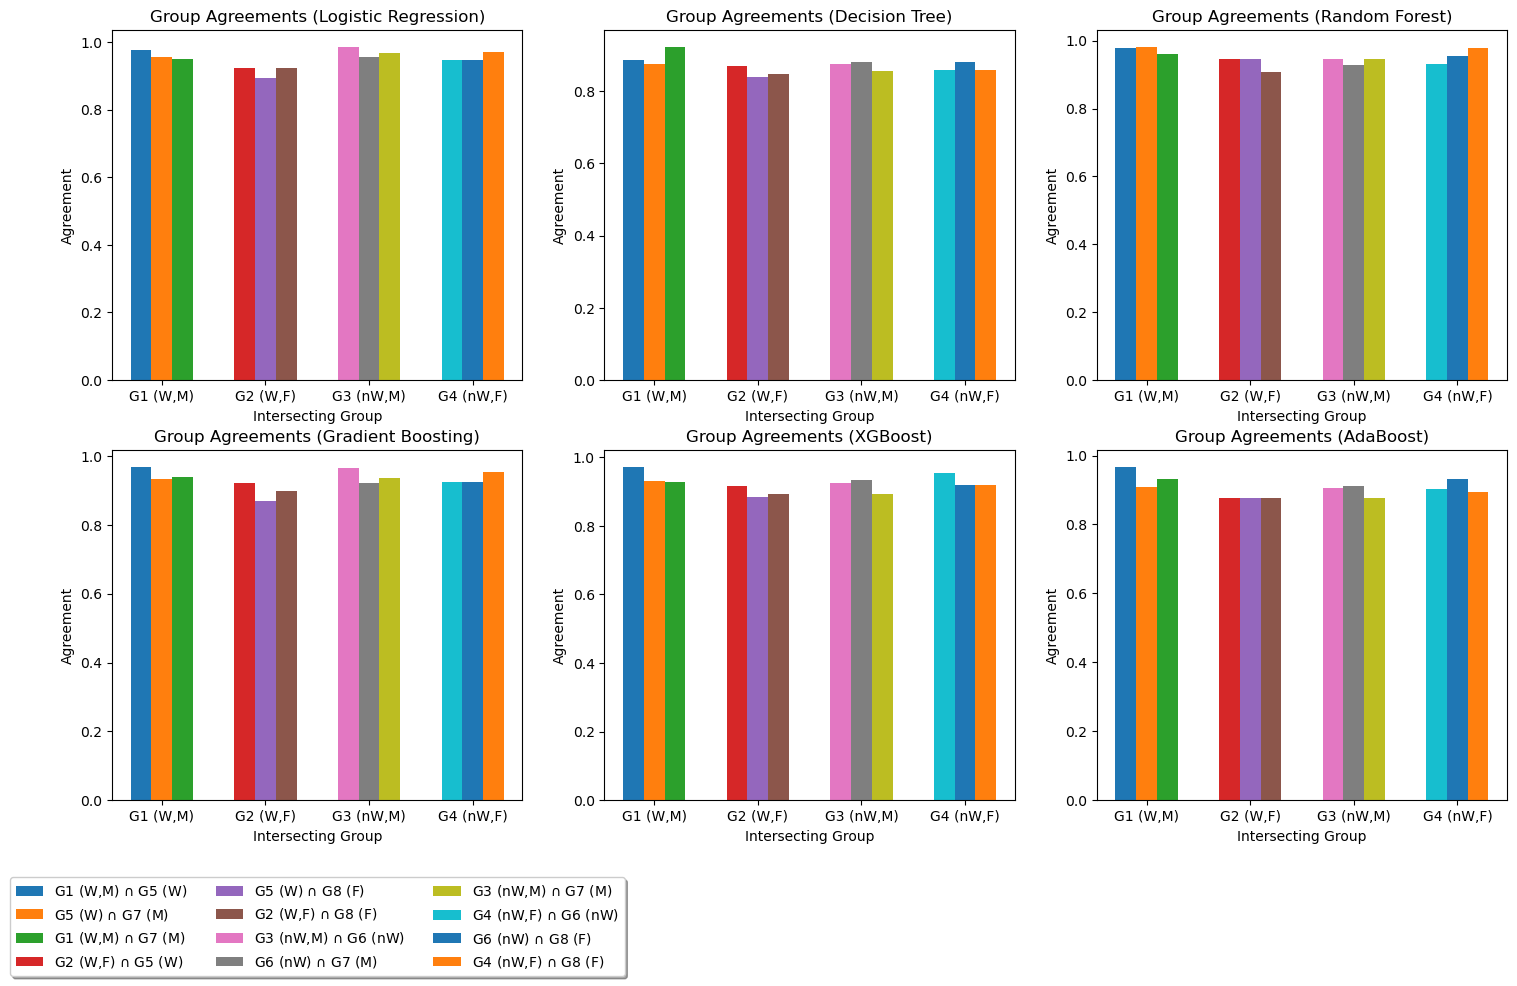

In [47]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18, 10)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

plot_compas_agreements(ax[0][0], lr_group_pairs_agreements, group_pairs, group_names, model_class="Logistic Regression", legend=False)
plot_compas_agreements(ax[0][1], dt_group_pairs_agreements, group_pairs, group_names, model_class="Decision Tree", legend=False)
plot_compas_agreements(ax[0][2], rf_group_pairs_agreements, group_pairs, group_names, model_class="Random Forest", legend=False)
plot_compas_agreements(ax[1][0], gb_group_pairs_agreements, group_pairs, group_names, model_class="Gradient Boosting", legend=False)
plot_compas_agreements(ax[1][1], xgb_group_pairs_agreements, group_pairs, group_names, model_class="XGBoost", legend=False)
plot_compas_agreements(ax[1][2], ada_group_pairs_agreements, group_pairs, group_names, model_class="AdaBoost", legend=False)

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

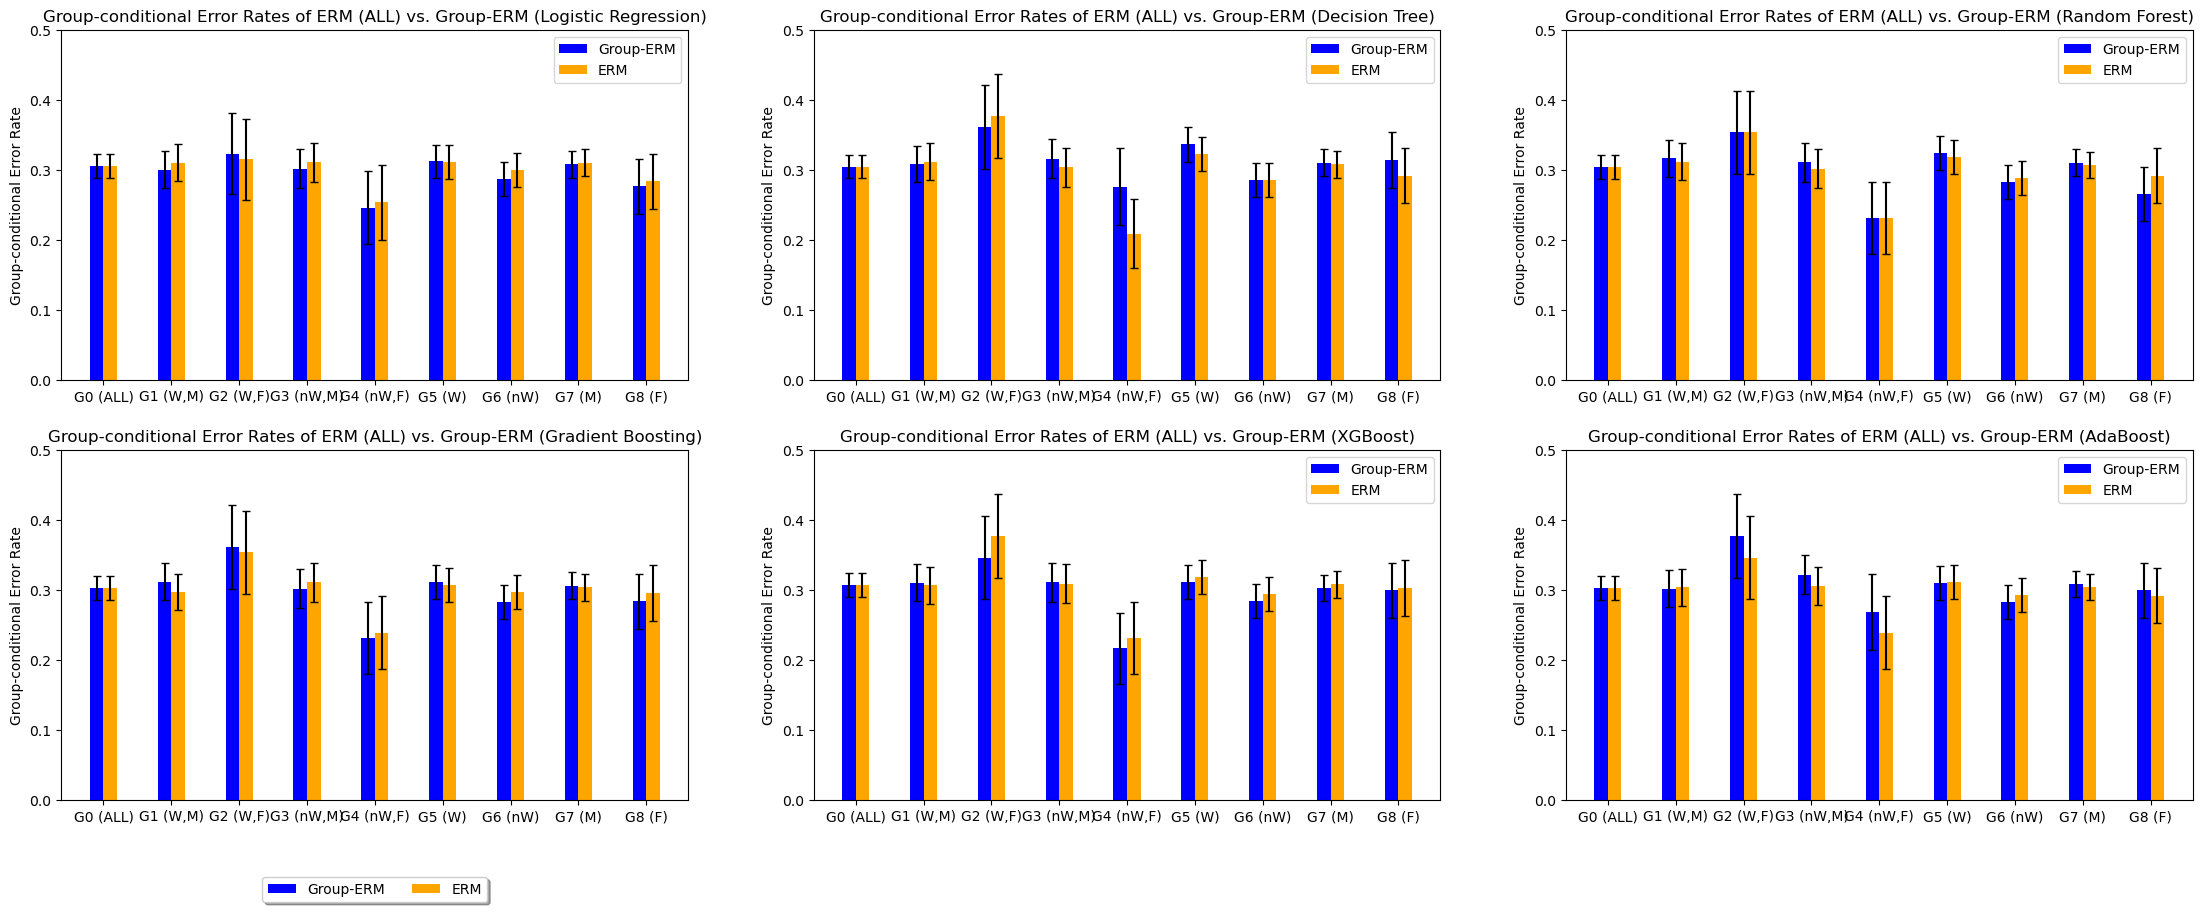

In [50]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(27.5, 10)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

plot_compas_errors(ax[0][0], lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err, model_class="Logistic Regression")
plot_compas_errors(ax[0][1], dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err, model_class="Decision Tree")
plot_compas_errors(ax[0][2], rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err, model_class="Random Forest")
plot_compas_errors(ax[1][0], gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err, model_class="Gradient Boosting")
plot_compas_errors(ax[1][1], xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err, model_class="XGBoost")
plot_compas_errors(ax[1][2], ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err, model_class="AdaBoost")

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()